### Correlation between acoustic features and brain activity

This analysis extracts the RMSE for each subsection of the story (and for each language group), resamples it to have the same length as the fMRI data, and then performs a simple correlation against the group averaged time course. We refrain here from running individual GLMs because the group results would turn out to be the same (logically), except for the former being statistically thresholded to account for outliers. However, given that this is simply a manipulation check, it is ok to show that the RMSE acoustics features and the fMRI time course in the auditory cortex are well-aligned.

#### Import modules and set up filepaths

In [1]:
from scipy.io import wavfile
import numpy as np
import pandas as pd
from pliers.extractors import RMSExtractor
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import zscore
import nilearn
from nilearn import plotting, input_data

fmripath  = "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/"
audiopath = "../../data_lpp/story_data/" 

titles        = ['FR-01',
                 'CN-01',
                 'EN-01',
                 'FR-02',
                 'CN-02',
                 'EN-02',
                 'FR-03',
                 'CN-03',
                 'EN-03',
                 'FR-04',
                 'CN-04',
                 'EN-04',
                 'FR-05',
                 'CN-05',
                 'EN-05',
                 'FR-06',
                 'CN-06',
                 'EN-06',
                 'FR-07',
                 'CN-07',
                 'EN-07',
                 'FR-08',
                 'CN-08',
                 'EN-08',
                 'FR-09',
                 'CN-09',
                 'EN-09',]

fmripaths     = ['task-lppFR-run-01.npy',
                 'task-lppCN-run-01.npy',
                 'task-lppEN-run-01.npy',
                 'task-lppFR-run-02.npy',
                 'task-lppCN-run-02.npy',
                 'task-lppEN-run-02.npy',
                 'task-lppFR-run-03.npy',
                 'task-lppCN-run-03.npy',
                 'task-lppEN-run-03.npy',
                 'task-lppFR-run-04.npy',
                 'task-lppCN-run-04.npy',
                 'task-lppEN-run-04.npy',
                 'task-lppFR-run-05.npy',
                 'task-lppCN-run-05.npy',
                 'task-lppEN-run-05.npy',
                 'task-lppFR-run-06.npy',
                 'task-lppCN-run-06.npy',
                 'task-lppEN-run-06.npy',
                 'task-lppFR-run-07.npy',
                 'task-lppCN-run-07.npy',
                 'task-lppEN-run-07.npy',
                 'task-lppFR-run-08.npy',
                 'task-lppCN-run-08.npy',
                 'task-lppEN-run-08.npy',
                 'task-lppFR-run-09.npy',
                 'task-lppCN-run-09.npy',
                 'task-lppEN-run-09.npy',]

audiopaths    = ['lpp_fr_audio/stimuli_task-lppFR_section-1.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-1.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-1.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-2.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-2.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-2.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-3.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-3.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-3.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-4.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-4.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-4.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-5.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-5.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-5.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-6.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-6.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-6.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-7.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-7.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-7.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-8.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-8.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-8.wav',
                 'lpp_fr_audio/stimuli_task-lppFR_section-9.wav',
                 'lpp_cn_audio/stimuli_task-lppCN_section-9.wav',
                 'lpp_en_audio/stimuli_task-lppEN_section-9.wav',]

textgridpaths = ['lpp_fr_audio/annotation_FR_lppFR_section1.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section1.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section1.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section2.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section2.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section2.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section3.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section3.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section3.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section4.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section4.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section4.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section5.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section5.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section5.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section6.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section6.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section6.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section7.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section7.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section7.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section8.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section8.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section8.TextGrid.csv',
                 'lpp_fr_audio/annotation_FR_lppFR_section9.TextGrid.csv',
                 'lpp_cn_audio/annotation_CN_lppCN_section9.TextGrid.csv',
                 'lpp_en_audio/annotation_EN_lppEN_section9.TextGrid.csv']

# set up masker
shen_file       = '../../data_lpp/fmri_data/other/shen_2mm_268_parcellation.nii'
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);
sample_file = '../../data_lpp/fmri_data/other/func.nii'
shen_masker.fit_transform(sample_file);

### fMRI data

In [2]:
images_list = []

for curr in range(len(titles)):
    #print(curr)
    curr_title = titles[curr]
    #print(curr_title)
    fmri_file  = fmripath  + fmripaths[curr]
    audio_file = audiopath + audiopaths[curr]
    text_file  = audiopath + textgridpaths[curr]
    text = pd.read_csv(text_file)

    curr_data = np.load(fmri_file)
    curr_data.shape

    TR = 2.0 
    curr_trs = curr_data.shape[0]
    #print(curr_trs)    
    lenght_fmri_sec = curr_data.shape[0]* TR

    mins, secs = divmod(lenght_fmri_sec, 60)
    fstr = str(int(mins)) + ':' + str(secs) 
    #print("Scan duration: "+ fstr)

    curr_run=0
    samplerate, wavdata = wavfile.read(audio_file)
    seconds = float(wavdata.shape[0])/samplerate
    #print("Wav Duration Secs: "+ str(seconds))

    mins, secs = divmod(seconds, 60)
    tstr = str(int(mins)) + ':' + str(secs) 
    #print("Wav Duration: "+ tstr)

    last_word_end = text.iloc[-1].onset
    #print("Last word Secs: " + str(last_word_end))

    wmins, wsecs = divmod(last_word_end, 60)
    wstr = str(int(wmins)) + ':' + str(wsecs) 
    #print("Last word: "+ wstr)

    # compute the audioresample:
    ext = RMSExtractor()

    audio_temp = '../../data_lpp/story_data/' + curr_title  + '_temp.wav'
    wavfile.write(audio_temp, samplerate, wavdata[:int(last_word_end*samplerate)] )
    rms_result = ext.transform(audio_temp)
    rms_result_df = rms_result.to_df()
    rms_result_df

    res_rms = signal.resample(rms_result_df['rms'].values, wavdata.shape[0])
    
    resmat_all = np.nanmean(curr_data, axis = 2)
    #print(resmat_all.shape)
    
    if ((curr_title[:2]=='EN') or (curr_title[:2]=='FR')):
        #print(str(-4))
        resmat_all = resmat_all[:-4, : ]
    else:
        print(str('ok'))
    downsampled_resrms = signal.resample(rms_result_df['rms'].values, resmat_all.shape[0])

    res      = []
    tr_shift = 2
    trans=10
    res = []
    for i in range(268):
                res.append(np.corrcoef(zscore(resmat_all[(trans+tr_shift):(-trans), i]), 
                                       zscore(downsampled_resrms[(trans):(-trans-tr_shift)]))[0,1])
    res = np.asarray(res)
    res[(res > -0.03) & (res<0.03) ] = 0
    res_img = shen_masker.inverse_transform( np.reshape(res, (1,268)) );
    images_list.append(nilearn.image.index_img(res_img,0))

ok
ok
ok
ok
ok
ok
ok
ok
ok


### Plot overall

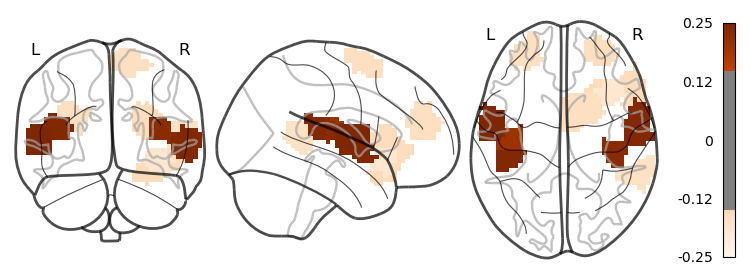

In [3]:
alli = nilearn.image.concat_imgs(images_list) 
meani = nilearn.image.mean_img(alli)
plotting.plot_glass_brain(meani, 
                          colorbar  = True, 
                          annotate  = True,
                          cmap      = "Oranges", 
                          threshold = 0.15,
                          vmax      = 0.25,
                          plot_abs  = False, 
                         );

In [4]:
images_list

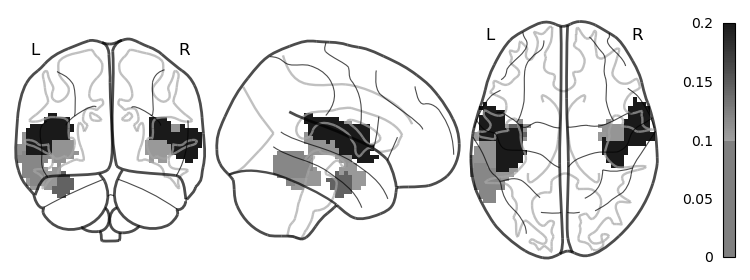

In [5]:
import nilearn
from nilearn import image

alli = nilearn.image.concat_imgs(images_list) 


meani = nilearn.image.mean_img(alli)
threshed_image = nilearn.image.math_img("np.ma.masked_less_equal(img, 0)", img=meani)

plotting.plot_glass_brain(threshed_image, 
                          colorbar  = True, 
                          annotate  = True,
                          cmap      = "RdGy", 
                          threshold = 0.1,
                          vmax      = 0.2,
                          plot_abs  = False, 
                         );

### Plot timecourse (example)
last section (9), english

Correlation: 0.35


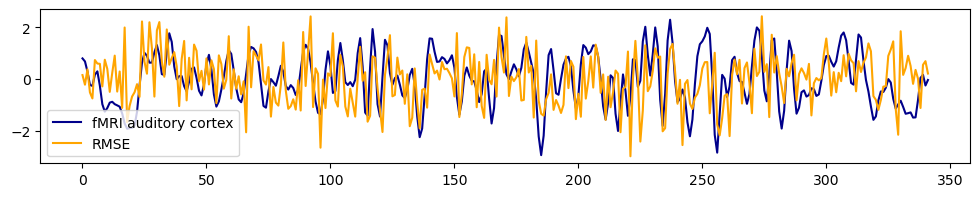

In [6]:
region = 61
plt.figure(figsize = (12,2));
plt.plot(zscore(resmat_all[(trans+tr_shift):(-trans), region]), color = 'darkblue', label = 'fMRI auditory cortex');
plt.plot(zscore(downsampled_resrms[(trans):(-trans-tr_shift)]), color = 'orange', label = 'RMSE');
plt.legend()
r = np.corrcoef(resmat_all[(trans+tr_shift):(-trans), region], 
           downsampled_resrms[(trans):(-trans-tr_shift)])[0,1]
print('Correlation: ' + str(np.round(r,2)))

### Plot for each language

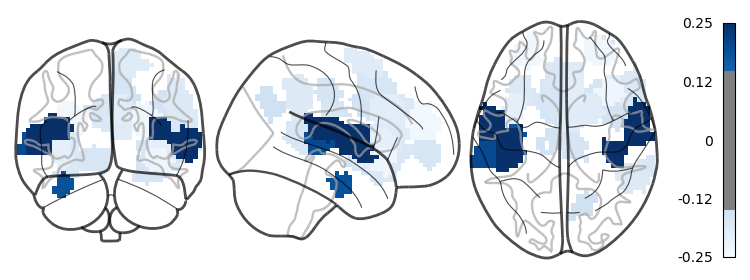

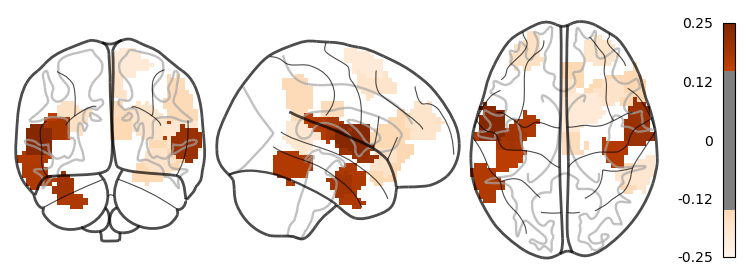

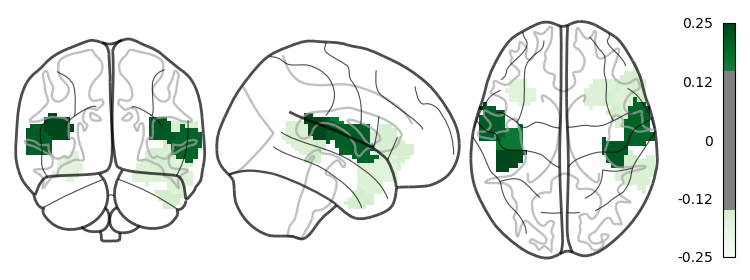

In [7]:
fri = nilearn.image.concat_imgs( [images_list[i] for i in np.arange(0,27,3)] ) 
meanfri  = nilearn.image.mean_img(fri )
plotting.plot_glass_brain(meanfri, colorbar = True, annotate = False, cmap = "Blues", 
                          display_mode = 'ortho', threshold = 0.15, vmax = 0.25, plot_abs  = False);

cni = nilearn.image.concat_imgs( [images_list[i] for i in np.arange(1,27,3)] ) 
meancni  = nilearn.image.mean_img(cni )
plotting.plot_glass_brain(meancni, colorbar = True, annotate = False, cmap = "Oranges", 
                          display_mode = 'ortho', threshold = 0.15, vmax = 0.25, plot_abs  = False);

eni = nilearn.image.concat_imgs( [images_list[i] for i in np.arange(2,27,3)] ) 
meaneni  = nilearn.image.mean_img(eni )
plotting.plot_glass_brain(meaneni, colorbar = True, annotate = False, cmap = "Greens", 
                          display_mode = 'ortho', threshold = 0.15, vmax = 0.25, plot_abs  = False);

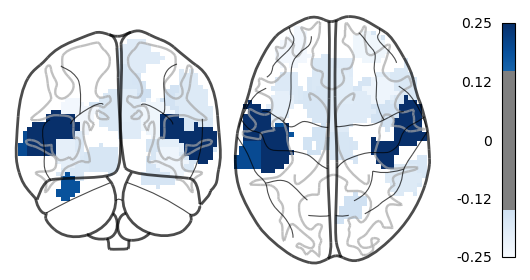

In [8]:
fri = nilearn.image.concat_imgs( [images_list[i] for i in np.arange(0,27,3)] ) 
meanfri  = nilearn.image.mean_img(fri )
plotting.plot_glass_brain(meanfri, colorbar = True, annotate = False, cmap = "Blues", 
                          display_mode = 'yz', threshold = 0.15, vmax = 0.25, plot_abs  = False);



### Plot inidividual sections

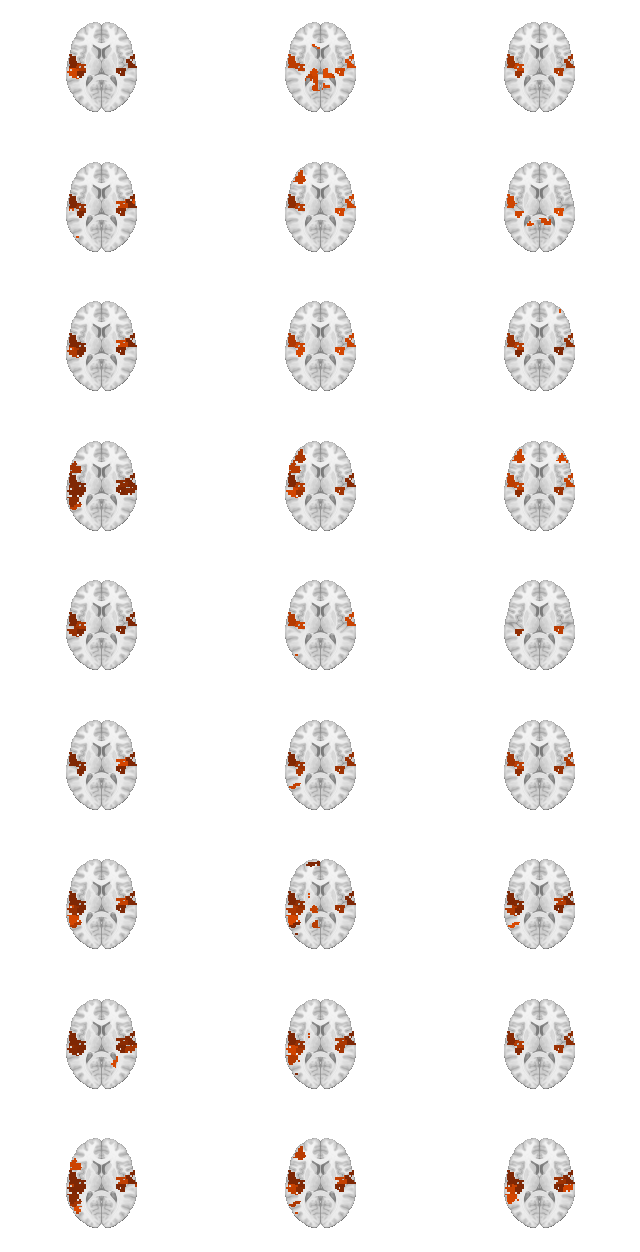

In [9]:
f = plt.figure(figsize=(8,16))

for curr in range(27):
    the_img = images_list[curr]
    ax = f.add_subplot(9,3, curr + 1)
    curr_title = titles[curr]
    threshed_image = nilearn.image.math_img("np.ma.masked_less_equal(img, 0)", img=the_img)
    plotting.plot_stat_map(threshed_image, 
                          colorbar   = False, 
                          annotate   = False,
                          cmap       = "Oranges",
                          display_mode = 'z',
                          cut_coords = [10],
                          threshold  = 0.12,
                          vmax       = 0.25,
                          axes       = ax,
                          #title      = str(curr+1),
                          );
    
    

1
4
7
10
13
16
19
22
25


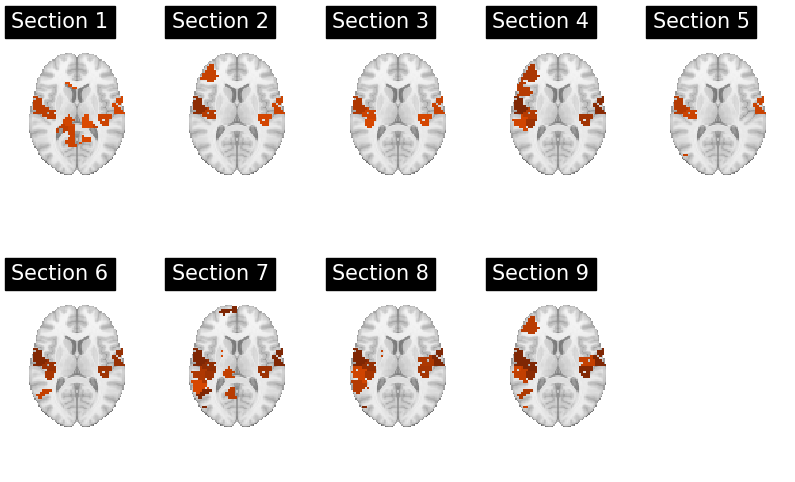

In [10]:
select = np.arange(1,27,3)
len(select)

f = plt.figure(figsize=(10,6))

for run in range(len(select)):
    curr = select[run]
    print(curr)
    the_img = images_list[curr]
    ax = f.add_subplot(2,5, run + 1)
    curr_title = titles[curr]
    threshed_image = nilearn.image.math_img("np.ma.masked_less_equal(img, 0)", img=the_img)
    plotting.plot_stat_map(threshed_image, 
                          colorbar   = False, 
                          annotate   = False,
                          cmap       = "Oranges",
                          display_mode = 'z',
                          cut_coords = [10],
                          threshold  = 0.12,
                          vmax       = 0.25,
                          axes       = ax,
                          title      = 'Section ' +str(run+1),
                          );
    
    